<a href="https://colab.research.google.com/github/deovrat-n/Drug-Reaction-In-Patients-NER/blob/main/Drug_Reaction_in_Patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a NER from  scratch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

## Reading Data

In [ ]:
!gdown 1ao5aINQqedAWHSXGLpAVzW1iEZj7sZ5_
!gdown 15RuVEDqO592th-44iVEpcGbtvX9RjDWR

Downloading...
From: https://drive.google.com/uc?id=1ao5aINQqedAWHSXGLpAVzW1iEZj7sZ5_
To: /content/ner_dataset.csv
100% 15.2M/15.2M [00:00<00:00, 180MB/s]
Downloading...
From: https://drive.google.com/uc?id=15RuVEDqO592th-44iVEpcGbtvX9RjDWR
To: /content/drugsComTrain_raw.csv
100% 1.38M/1.38M [00:00<00:00, 132MB/s]


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NER dataset/Dataset/ner_dataset.csv", encoding="latin1")


# Show the first 10 rows
data.head(n=10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


We see in column "Sentence #"  sentence 1 is followed by NaN, so we need to fill the same we whatever the value is in top

In [ ]:
data = data.fillna(method="ffill")
data.head(n=24)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


Now, this looks better.

As we see the dataset has 4 columns 
- Sentence # (the sentence number)
- Word
- POS
- Tag (the annotation which is manually labelled against each word)

This method of labelling is known as sequence labelling. Let's take a look at some of the numbers./

In [ ]:
data.shape

(1048575, 4)

In [ ]:
print("Number of sentences: ", len(data.groupby(['Sentence #'])))


Number of sentences:  47959


In [ ]:
words = list(set(data["Word"].values))
n_words = len(words)
print("Number of unique words in the dataset: ", n_words)

Number of unique words in the dataset:  35178


The number of words is less than number of sentence. Its becuase we can have same word in different sentences.

In [ ]:
n_tags = len(data.groupby(['Tag']))
print("Number of Labels: ", n_tags)


Number of Labels:  17


In [ ]:
tags = list(set(data["Tag"].values))
print("Tags:", tags)

Tags: ['I-art', 'I-nat', 'B-gpe', 'I-eve', 'I-gpe', 'I-tim', 'B-art', 'B-eve', 'B-geo', 'I-geo', 'O', 'B-nat', 'B-per', 'I-org', 'B-tim', 'I-per', 'B-org']


<b>

- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon
    
</b>

In [ ]:
#let's check the frequency of each tag
data['Tag'].value_counts() 

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

We can see the <b> GEO (gepgraphic location) tag has the max frequency </b>, followed by time entity.


## Preprocessing

For Preprocessing, we will first put each sentence through a function which will <b> put each of the words along with its POS and Tag together in a tuple</b>. Each sentence will form a list of tuples.

In [ ]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_n, Tag_n)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


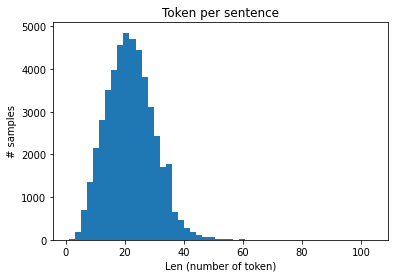

In [ ]:
# Get all the sentences
sentences = getter.sentences
# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

From the histogram, we can see most of the sentences have around <b> 15 to 30 tokens </b>. Tokens can we referred as words ignoring punctuation marks.

- <b>Further PreProcessing:</b>

- We will convert each text word to a corresponding integer ID using the <b> word2idx dictionary</b>. Doing so saves a lot of memory.
- In order to feed the data to out Bi-LSTM-CRF model, we need to ensure that all text should be of the same length. 
 - The method sequence.pad_sequences() and variable MAX_LEN are used for this purpose.
 - The text which are shorter than MAX_LEN are padded to get them to the same length, whereas text which are longer than MAX_LEN are truncated.

In [ ]:
import sklearn

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


The word Obama is identified by the index: 12958
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 9


In [ ]:
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical

# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


print('Raw Sample:\n ', ' '.join([w[0] for w in sentences[0]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[2] for w in sentences[0]]))
print('\n ' )
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Sample:
  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

 
Raw Label:
  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O

 
After processing, sample:
 [ 3098 14720   364 34999 25900 32206 13933 20204 27545 24264 18638 29676
 30863  4828 32046 24264 25851 14720 12446  2695 31516 12600 15776  7242
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## Model Building - Bi-LSTM + CRF

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 11.8 MB/s 


In [ ]:
# from keras.models import Model, Input
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
#from keras_contrib.layers import CRF
from tensorflow_addons.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics ='accuracy')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 20)            703600    
                                                                 
 bidirectional (Bidirectiona  (None, 75, 100)          28400     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 75, 50)           5050      
 ibuted)                                                         
                                                                 
 crf (CRF)                   [(None, 75),              1278      
                              (None, 75, 18),                    
                              (None,),                       

Now, let's again go back to our original ask.
- We need to find relation between drug name and problems it is causing.

### But there are <b> 2 obstacles </b> :
- But we <b>don't have any entity</b> tags which talk either about <b>drug name</b> or <b> side effects/problems/diseases </b>. 
- We <b> need a lot of annotated data from a specific domain </b> (in this case BioMedical data)

### How do we tackle it?

The answer is we use a pre-trained domain specific NER. There are domain specific NERs such as banking, e-commerce, manufacturing, bio-medical NER.  

Before that, let's check the dataset which has review data from a pharma company.

In [ ]:
raw_df=pd.read_csv('/content/drive/MyDrive/NER dataset/Dataset/drugsComTrain_raw.csv', encoding='iso-8859-1')
raw_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461.0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,20-May-12,27.0
1,95260.0,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,27-Apr-10,192.0
2,92703.0,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,14-Dec-09,17.0
3,138000.0,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,03-Nov-15,10.0
4,35696.0,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,27-Nov-16,37.0


We can see, the data has these important columns:
<b>
1. drugName
2. condition
3. review
</b>
Let's take a look at one of review, and understand how a <b> SME would have labelled it manually. </b>

In [ ]:
print('Review Number:',raw_df['uniqueID'][0])
print('Drug Name:',raw_df['drugName'][0])
print('Review:',raw_df['review'][0])

Review Number: 206461.0
Drug Name: Valsartan
Review: "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"


And we see, for review number 206461, there were <b> no side-effects or problem </b> being caused by the drug Valsartan. Let's take a look at another example.

In [ ]:
print('Review Number:',raw_df['uniqueID'][15])
print('Drug Name:',raw_df['drugName'][15])
print('Review:',raw_df['review'][15])

Review Number: 81890.0
Drug Name: Liraglutide
Review: "I have been taking Saxenda since July 2016.  I had severe nausea for about a month once I got up to the 2.6 dosage.  It has since subsided and the only side effect I notice now is the dry mouth.  I make sure to drink  2.5 litres of water a day (about 10 glasses).  This helps with the weight loss as well as the constipation.  I have been reducing my dose to find a comfortable spot where I am still losing weight but don&#039;t feel like I am over medicating.  For me, 1.8 is working very well.  I also feel wearing a Fitbit has really helped.  I can track my food, water, exercise and steps - it keeps me moving more.  When this started I could barely walk the length of myself without getting winded - I have lost 58 lbs so far."


<b> Liraglutide </b> is a molecule used to treat type 2 diabetes and chronic weight management. Now, we can see there are some side-effects attached to it
- <b> dry mouth </b>
- <b>nausea </b>

So, as we get closer to the ask. We need to map Liraglutide with dry mouth and nausea. 

<b>But, how? </b>

Let's check what are the tools we have in hand. But before that, let's take a look at how a word cloud on this review column would look like:

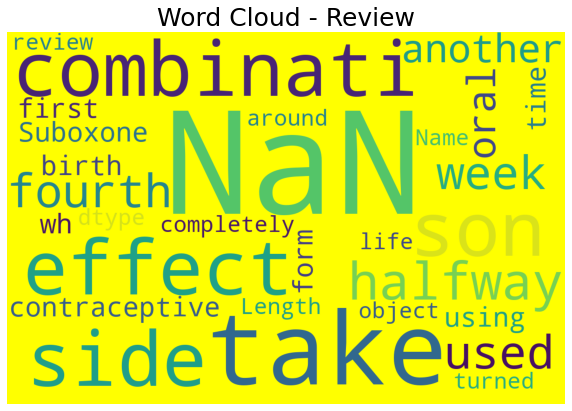

In [ ]:
# let's see the words cloud for the reviews 

# most popular drugs

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'yellow', stopwords = stopwords, width = 1200, height = 800).generate(str(raw_df['review']))

plt.rcParams['figure.figsize'] = (10, 15)
plt.title('Word Cloud - Review', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Not much information, is inferred from the word cloud. 

- We need a model which is pre-trained on Bio-Medical data and would be able to identify drug names and side-effects/symptoms and disease name. So here comes, stanza 

## Bio-Medical NER - Stanza

At a high level, Stanza currently provides packages that support <b> Universal Dependencies (UD)-compatible syntactic analysis </b> and named entity recognition (NER) from both English biomedical literature and clinical note text. Officially offered packages include:

- 2 UD-compatible biomedical syntactic analysis pipelines, trained with human-annotated treebanks;
- 1 UD-compatible clinical syntactic analysis pipeline, trained with silver data;


![Screenshot%202022-03-16%20184002.png](https://drive.google.com/uc?id=1FDU5qfDpm9w0EYqVmqymqy9LtabhBeJy)
- 8 accurate biomedical NER models augmented with contextualized representations;
- 2 clinical NER models, including one specialized in radiology reports.



![Screenshot%202022-03-16%20183750.png](https://drive.google.com/uc?id=15Omc0QfQzI9wer54ncHhtP8bGWzw1jBh)

The 16 entity types in the BioNLP13CG model include, some of which are:
- ORGAN
- ORGANISM
- PROBLEM
- TREATMENT
- DISEASE
- CHEMICAL

<B> Let's import stanza </b>

In [ ]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 12.8 MB/s 
     |████████████████████████████████| 240 kB 84.2 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=04aed0dd34eba27ef40e1af43a3c7a955ba19016b154e400949fcaf9c3f7bfc9
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [ ]:
import stanza
stanza.download('en', package='mimic',processors={'ner':'i2b2'})
stanza.download('en', package='mimic',processors={'ner':'bc5cdr'})

INFO:stanza:Downloading these customized packages for language: en (English)...
| Processor       | Package |
-----------------------------
| tokenize        | mimic   |
| pos             | mimic   |
| lemma           | mimic   |
| depparse        | mimic   |
| ner             | i2b2    |
| pretrain        | mimic   |
| forward_charlm  | mimic   |
| backward_charlm | mimic   |



INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


INFO:stanza:Downloading these customized packages for language: en (English)...
| Processor       | Package |
-----------------------------
| tokenize        | mimic   |
| pos             | mimic   |
| lemma           | mimic   |
| depparse        | mimic   |
| ner             | bc5cdr  |
| backward_charlm | pubmed  |
| forward_charlm  | pubmed  |
| backward_charlm | mimic   |
| pretrain        | craft   |
| pretrain        | mimic   |
| forward_charlm  | mimic   |

INFO:stanza:File exists: /root/stanza_resources/en/tokenize/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/pos/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/lemma/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/depparse/mimic.pt


INFO:stanza:File exists: /root/stanza_resources/en/backward_charlm/mimic.pt


INFO:stanza:File exists: /root/stanza_resources/en/pretrain/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/forward_charlm/mimic.pt
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


Because, within the data we already have drug name, we need PROBLEM and DISEASE entity identification only, we are downloading only two NER models
<b>
1. i2b2
2. bc5cdr
</b>

So, let us create two pipeline with these

In [ ]:
nlp1 = stanza.Pipeline('en', package='mimic', processors={'ner':'i2b2'})
nlp2= stanza.Pipeline('en', package='mimic', processors={'ner':'bc5cdr'})

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| pos       | mimic   |
| lemma     | mimic   |
| depparse  | mimic   |
| ner       | i2b2    |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| pos       | mimic   |
| lemma     | mimic   |
| depparse  | mimic   |
| ner       | bc5cdr  |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
#Let's check a sample sentence with i2b2
doc = nlp1("This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch")
doc.entities

[{
   "text": "birth control",
   "type": "TREATMENT",
   "start_char": 40,
   "end_char": 53
 }, {
   "text": "the patch",
   "type": "TREATMENT",
   "start_char": 81,
   "end_char": 90
 }, {
   "text": "my cramps",
   "type": "PROBLEM",
   "start_char": 305,
   "end_char": 314
 }, {
   "text": "cramps",
   "type": "PROBLEM",
   "start_char": 372,
   "end_char": 378
 }, {
   "text": "birth control",
   "type": "TREATMENT",
   "start_char": 392,
   "end_char": 405
 }, {
   "text": "the patch",
   "type": "TREATMENT",
   "start_char": 437,
   "end_char": 446
 }]

So if we see what is being detected through NER, 
<b>
- cramps (problem)
- birth control (treatment)
- patch (treatment)
</b>

![Screenshot%202022-03-16%20190006.png](https://drive.google.com/uc?id=1dJUVi6MUdnct0miPjSNSA1iRLHHLGJT0)

Let's do the same with <b> bc5cdr</b>

In [ ]:
#Let's check a sample sentence with i2b2
doc = nlp2("This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch")
doc.entities

[{
   "text": "cramps",
   "type": "DISEASE",
   "start_char": 308,
   "end_char": 314
 }, {
   "text": "cramps",
   "type": "DISEASE",
   "start_char": 372,
   "end_char": 378
 }]

![Screenshot%202022-03-25%20145818.png](https://drive.google.com/uc?id=1PsXq6HjerNVOAUAZW0lBQioNfpz74Jxl)

We see almost the same results, just the name of the entities differ. We will choose bc5cdr, as of now.

In [ ]:
#slicing the first 50 rows, keeping the time factor in mind

df = raw_df.head(50)
df['Side-Effects']=''

for i, row in df.iterrows():
    doc=nlp2(row["review"])
    doc_entity=doc.entities
    #print(doc_entity)
    ae=[]
        
    for token in doc_entity:
        #print(token.type)
        if token.type=="DISEASE":
            ae.append(token.text)
            #print(ae)
    
    df.at[i,'Side-Effects']=ae
            

<ipython-input-34-dac5c8bdb0ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Side-Effects']=''


In [ ]:
df.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,Side-Effects
0,206461.0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,20-May-12,27.0,[]
1,95260.0,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,27-Apr-10,192.0,[]
2,92703.0,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,14-Dec-09,17.0,[]
3,138000.0,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,03-Nov-15,10.0,"[cramps, cramps]"
4,35696.0,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,27-Nov-16,37.0,[constipation]
5,155963.0,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2.0,28-Nov-15,43.0,[headache]
6,165907.0,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1.0,07-Mar-17,5.0,[]
7,102654.0,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10.0,14-Mar-15,32.0,"[depression, depressed, Bi-polar disorder]"
8,74811.0,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1.0,09-Aug-16,11.0,[]
9,48928.0,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8.0,08-Dec-16,1.0,"[acne, acne, depression, weight gain, depressed]"


We can see, the Disease column have picked <b> a lot of symptoms/side-effects </b>. Now it's time to put them together.

In [ ]:
#keep only the relevant cols and the rows with non-empty side-effects
cols_rel=['drugName','Side-Effects']
df_rel= df.loc[:,cols_rel]
df_rel=df_rel[df_rel["Side-Effects"].astype(bool)]
df_rel.head()

,drugName,Side-Effects
3,Ortho Evra,"[cramps, cramps]"
4,Buprenorphine / naloxone,[constipation]
5,Cialis,[headache]
7,Aripiprazole,"[depression, depressed, Bi-polar disorder]"
9,Ethinyl estradiol / levonorgestrel,"[acne, acne, depression, weight gain, depressed]"


In [ ]:
#  create a list to host each problem with the drugname
list=[]
for i,row in df_rel.iterrows():
    for ele in enumerate(row['Side-Effects']):
        #print(row['drugName'],ele[1])
        list.append((row['drugName'],ele[1]))
        
     

In [ ]:
#convert the list into a dataframe
df_drug_problem = pd.DataFrame(list,columns = ['drugName', 'Side-Effects'])
df_drug_problem.head(10)

,drugName,Side-Effects
0,Ortho Evra,cramps
1,Ortho Evra,cramps
2,Buprenorphine / naloxone,constipation
3,Cialis,headache
4,Aripiprazole,depression
5,Aripiprazole,depressed
6,Aripiprazole,Bi-polar disorder
7,Ethinyl estradiol / levonorgestrel,acne
8,Ethinyl estradiol / levonorgestrel,acne
9,Ethinyl estradiol / levonorgestrel,depression


In [ ]:
#but we see some duplicates
df_drug_problem.drop_duplicates(subset=None,keep='first',inplace=False)

,drugName,Side-Effects
0,Ortho Evra,cramps
2,Buprenorphine / naloxone,constipation
3,Cialis,headache
4,Aripiprazole,depression
5,Aripiprazole,depressed
...,...,...
105,Tamsulosin,Memory problems
106,Tamsulosin,runny nose
107,Tamsulosin,weakness
108,Tamsulosin,tiredness


In [ ]:
df_drug_problem['drugName'].value_counts() 

Lamotrigine                           8
Trazodone                             8
Tamsulosin                            7
Dulcolax                              6
Amitriptyline                         6
Ethinyl estradiol / levonorgestrel    5
Ledipasvir / sofosbuvir               5
Dextromethorphan                      5
Azithromycin                          4
Toradol                               4
Pentasa                               4
Liraglutide                           4
Atripla                               3
Trimethoprim                          3
Sertraline                            3
Contrave                              3
Topiramate                            3
Aripiprazole                          3
Imitrex                               3
Fluconazole                           2
Trilafon                              2
MoviPrep                              2
Ortho Evra                            2
Daytrana                              2
L-methylfolate                        2


So we see the top 5 drugName with the highest number of side-effects are :
<b>
- Trazodone                             
- Lamotrigine                           
- Tamsulosin                            
- Amitriptyline                         
- Dulcolax                              
</b>

## Scope for improvement


<b>1. Use BIO-Bert for Relationship extraction</b>
We can see some the problems are solved by that Drug as well, so if we can establish a relationship between the drugName and the side-effect that will give us a much refined insight about the drug

Further more we can also involve

<b>2. Knowledge Graph for Question and Answering purpose</b>
